# IPP temporal codec

Este notebook muestra el uso del códec IPP:

- GOP de 16 frames (1 I + 15 P)
- Predicción temporal con vectores de movimiento
- Uso de la imagen reconstruida como referencia
- Métricas de PSNR y CR

In [1]:
%%writefile ../src/IPP.py
import os
import time
import argparse
import numpy as np
from PIL import Image
from IPython.display import display


def load_frames_from_folder(frames_dir):
    files = sorted([f for f in os.listdir(frames_dir) if f.lower().endswith((".png",".jpg",".jpeg"))])
    frames = []
    for f in files:
        img = Image.open(os.path.join(frames_dir, f)).convert("RGB")
        frames.append(np.array(img, dtype=np.uint8))
    return frames, files

def save_frames_to_folder(frames, out_dir, prefix="recon_"):
    os.makedirs(out_dir, exist_ok=True)
    for i, fr in enumerate(frames):
        Image.fromarray(fr.astype(np.uint8)).save(os.path.join(out_dir, f"{prefix}{i:03d}.png"))

def compute_psnr(orig, recon, data_range=255.0):
    orig_f = orig.astype(np.float32)
    recon_f = recon.astype(np.float32)
    mse = np.mean((orig_f - recon_f)**2)
    if mse == 0:
        return float("inf")
    return 20 * np.log10(data_range / np.sqrt(mse))

def quantize_residual(residual, q_step):
    return np.round(residual / float(q_step)).astype(np.int16)

def dequantize_residual(res_q, q_step):
    return (res_q.astype(np.int16) * int(q_step)).astype(np.int16)

def compute_residual(target, predicted):
    return target.astype(np.int16) - predicted.astype(np.int16)

def reconstruct_from_residual(predicted, residual):
    rec = predicted.astype(np.int16) + residual
    return np.clip(rec, 0, 255).astype(np.uint8)

# ==========================
#   MOTION ESTIMATION
# ==========================

def block_motion_estimation_mv(ref, target, block_size=16, search_range=2):
    H, W, _ = ref.shape
    H_blocks = H // block_size
    W_blocks = W // block_size
    mv = np.zeros((H_blocks, W_blocks, 2), dtype=np.int16)

    ref_f = ref.astype(np.float32)
    tgt_f = target.astype(np.float32)

    for by in range(H_blocks):
        for bx in range(W_blocks):
            y0 = by * block_size
            x0 = bx * block_size
            block_t = tgt_f[y0:y0+block_size, x0:x0+block_size, :]

            best_err = np.inf
            best_dy = 0
            best_dx = 0

            for dy in range(-search_range, search_range+1):
                for dx in range(-search_range, search_range+1):
                    yy = y0 + dy
                    xx = x0 + dx
                    if yy < 0 or xx < 0 or yy + block_size > H or xx + block_size > W:
                        continue
                    block_r = ref_f[yy:yy+block_size, xx:xx+block_size, :]
                    err = np.mean((block_t - block_r)**2)
                    if err < best_err:
                        best_err = err
                        best_dy = dy
                        best_dx = dx

            mv[by, bx, 0] = best_dy
            mv[by, bx, 1] = best_dx

    return mv

def apply_motion_vectors_mv(ref, motion_vectors, block_size=16):
    H, W, _ = ref.shape
    H_blocks, W_blocks, _ = motion_vectors.shape
    ref_f = ref.astype(np.float32)
    pred = np.zeros_like(ref_f)

    for by in range(H_blocks):
        for bx in range(W_blocks):
            y0 = by * block_size
            x0 = bx * block_size
            dy, dx = motion_vectors[by, bx]
            yy = y0 + dy
            xx = x0 + dx
            block_ref = ref_f[yy:yy+block_size, xx:xx+block_size, :]
            pred[y0:y0+block_size, x0:x0+block_size, :] = block_ref

    return np.clip(pred, 0, 255).astype(np.uint8)

# ==========================
#   PARÁMETROS IPP
# ==========================

GOP_SIZE = 16
q_step = 16

USE_MV = True
MV_BLOCK = 16
MV_RANGE = 2

# ==========================
#   ENCODER
# ==========================

def encoder_main():
    ROOT = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
    FRAMES_DIR = os.path.join(ROOT, "frames")
    COMP_DIR = os.path.join(ROOT, "compressed")
    os.makedirs(COMP_DIR, exist_ok=True)

    frames, filenames = load_frames_from_folder(FRAMES_DIR)
    if not frames:
        print("No hay frames en la carpeta frames/.")
        return

    num_frames = len(frames)
    num_gops = (num_frames + GOP_SIZE - 1) // GOP_SIZE

    t0 = time.time()

    for g in range(num_gops):
        start = g * GOP_SIZE
        end = min(start + GOP_SIZE, num_frames)
        gop = frames[start:end]
        gop_names = filenames[start:end]

        # I-frame
        i_frame = gop[0]
        prev_rec = i_frame.copy() 

        motion_vectors_list = []
        residuals_q = []

        for t in range(1, len(gop)):
            curr = gop[t]

            # Predicción
            if USE_MV:
                mv = block_motion_estimation_mv(prev_rec, curr, block_size=MV_BLOCK, search_range=MV_RANGE)
                pred = apply_motion_vectors_mv(prev_rec, mv, block_size=MV_BLOCK)
            else:
                mv = None
                pred = prev_rec

            # Residual
            residual = compute_residual(curr, pred)
            residual_q = quantize_residual(residual, q_step)

            motion_vectors_list.append(mv)
            residuals_q.append(residual_q)

            prev_rec = np.clip(pred.astype(np.int16) + (residual_q.astype(np.int16) * q_step), 0, 255).astype(np.uint8)

        out_path = os.path.join(COMP_DIR, f"gop_{g:03d}.npz")
        np.savez(
            out_path,
            i_frame=i_frame,
            motion_vectors=np.array(motion_vectors_list, dtype=object),
            residuals_q=np.array(residuals_q, dtype=object),
            q_step=q_step,
            filenames=np.array(gop_names, dtype=object),
            use_mv=USE_MV
        )

        print(f"GOP {g} guardado en {out_path}")

    t1 = time.time()
    print("Codificación completa en {:.2f} s".format(t1 - t0))

# ==========================
#   DECODER
# ==========================

def decoder_main():
    ROOT = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
    COMP_DIR = os.path.join(ROOT, "compressed")
    RESULTS_DIR = os.path.join(ROOT, "results")
    os.makedirs(RESULTS_DIR, exist_ok=True)

    gop_files = sorted([f for f in os.listdir(COMP_DIR) if f.startswith("gop_") and f.endswith(".npz")])
    all_recon = []

    t0 = time.time()
    for gf in gop_files:
        data = np.load(os.path.join(COMP_DIR, gf), allow_pickle=True)

        i_frame = data["i_frame"]
        residuals_q = data["residuals_q"]
        q_step_local = int(data["q_step"])

        if "motion_vectors" in data:
            motion_vectors_arr = data["motion_vectors"]
        else:
            motion_vectors_arr = [None] * len(residuals_q)

        prev_rec = i_frame.copy()
        recon_frames = [prev_rec]

        for idx, res_q in enumerate(residuals_q):
            mv = motion_vectors_arr[idx]

            if mv is None:
                pred = prev_rec
            else:
                pred = apply_motion_vectors_mv(prev_rec, mv, block_size=16)

            residual = dequantize_residual(res_q, q_step_local)
            rec = reconstruct_from_residual(pred, residual)

            recon_frames.append(rec)
            prev_rec = rec

        gop_index = gf.split("_")[1].split(".")[0]
        save_frames_to_folder(recon_frames, RESULTS_DIR, prefix=f"gop{gop_index}_")
        all_recon.extend(recon_frames)
        print(f"GOP {gf} decodificado, frames: {len(recon_frames)}")

    t1 = time.time()
    print("Decodificación completa en {:.2f} s".format(t1 - t0))

# ==========================
#   TEST (PSNR y CR)
# ==========================

def test_main():
    ROOT = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
    FRAMES_DIR = os.path.join(ROOT, "frames")
    RESULTS_DIR = os.path.join(ROOT, "results")
    COMP_DIR = os.path.join(ROOT, "compressed")

    comp_files = sorted([f for f in os.listdir(COMP_DIR) if f.startswith("gop_") and f.endswith(".npz")])

    orig_frames, orig_names = load_frames_from_folder(FRAMES_DIR)

    recon_files = sorted([f for f in os.listdir(RESULTS_DIR) if f.startswith("gop") and f.endswith(".png")])
    recon_frames = [np.array(Image.open(os.path.join(RESULTS_DIR,f)).convert("RGB"), dtype=np.uint8) for f in recon_files]

    n = min(len(orig_frames), len(recon_frames))
    psnrs = []
    for i in range(n):
        p = compute_psnr(orig_frames[i], recon_frames[i])
        psnrs.append(p)
        print(f"Frame {i:03d} PSNR = {p:.2f} dB")

    mean_psnr = float(np.mean([v for v in psnrs if np.isfinite(v)])) if psnrs else 0.0
    print(f"\nPSNR medio (sin contar inf) = {mean_psnr:.2f} dB")

    total_orig = sum(fr.nbytes for fr in orig_frames)
    total_comp = sum(os.path.getsize(os.path.join(COMP_DIR,f)) for f in comp_files) if comp_files else 1
    cr = (total_orig * 1.0) / total_comp
    print(f"Tamaño original: {total_orig} bytes")
    print(f"Tamaño comprimido (sum gops): {total_comp} bytes")
    print(f"CR ≈ {cr:.2f}")

# ==========================
#   CLI PRINCIPAL
# ==========================

def main():
    parser = argparse.ArgumentParser(description="IPP temporal codec (GOP I+P)")
    subparsers = parser.add_subparsers(dest="command", required=True)

    subparsers.add_parser("encode", help="Codificar secuencia (frames -> compressed)")
    subparsers.add_parser("decode", help="Decodificar secuencia (compressed -> results)")
    subparsers.add_parser("test", help="Calcular PSNR y CR")

    args = parser.parse_args()

    if args.command == "encode":
        encoder_main()
    elif args.command == "decode":
        decoder_main()
    elif args.command == "test":
        test_main()
    else:
        parser.print_help()

if __name__ == "__main__":
    main()

Overwriting ../src/IPP.py


### Decisión I/P y uso de la referencia reconstruida

En cada GOP, el primer frame se codifica como I-frame, y los siguientes(15) como P-frames  
Cada P-frame se predice siempre a partir de la imagen reconstruida de frame anterior (prev_rec),garantizando que encoder y decoder usen la misma referencia

In [2]:
from IPython.display import Image, display
import os

In [3]:
!python ../src/IPP.py -h

usage: IPP.py [-h] {encode,decode,test} ...

IPP temporal codec (GOP I+P)

positional arguments:
  {encode,decode,test}
    encode              Codificar secuencia (frames -> compressed)
    decode              Decodificar secuencia (compressed -> results)
    test                Calcular PSNR y CR

options:
  -h, --help            show this help message and exit


In [4]:
%%bash
cd ..
python src/IPP.py encode

GOP 0 guardado en /home/kali/Documents/Sistemas Multimedia/ipp_codec/compressed/gop_000.npz
GOP 1 guardado en /home/kali/Documents/Sistemas Multimedia/ipp_codec/compressed/gop_001.npz
Codificación completa en 14.61 s


In [5]:
%%bash
cd ..
python src/IPP.py decode

GOP gop_000.npz decodificado, frames: 16
GOP gop_001.npz decodificado, frames: 14
Decodificación completa en 6.32 s


In [6]:
%%bash
cd ..
python src/IPP.py test

Frame 000 PSNR = inf dB
Frame 001 PSNR = 41.10 dB
Frame 002 PSNR = 41.17 dB
Frame 003 PSNR = 40.10 dB
Frame 004 PSNR = 39.95 dB
Frame 005 PSNR = 39.88 dB
Frame 006 PSNR = 39.87 dB
Frame 007 PSNR = 39.88 dB
Frame 008 PSNR = 39.17 dB
Frame 009 PSNR = 39.32 dB
Frame 010 PSNR = 39.43 dB
Frame 011 PSNR = 39.47 dB
Frame 012 PSNR = 39.53 dB
Frame 013 PSNR = 39.52 dB
Frame 014 PSNR = 39.31 dB
Frame 015 PSNR = 38.96 dB
Frame 016 PSNR = inf dB
Frame 017 PSNR = 39.36 dB
Frame 018 PSNR = 39.65 dB
Frame 019 PSNR = 39.98 dB
Frame 020 PSNR = 39.91 dB
Frame 021 PSNR = 38.17 dB
Frame 022 PSNR = 38.20 dB
Frame 023 PSNR = 37.78 dB
Frame 024 PSNR = 37.74 dB
Frame 025 PSNR = 37.94 dB
Frame 026 PSNR = 37.73 dB
Frame 027 PSNR = 37.80 dB
Frame 028 PSNR = 37.91 dB
Frame 029 PSNR = 37.58 dB

PSNR medio (sin contar inf) = 39.16 dB
Tamaño original: 82944000 bytes
Tamaño comprimido (sum gops): 177576642 bytes
CR ≈ 0.47


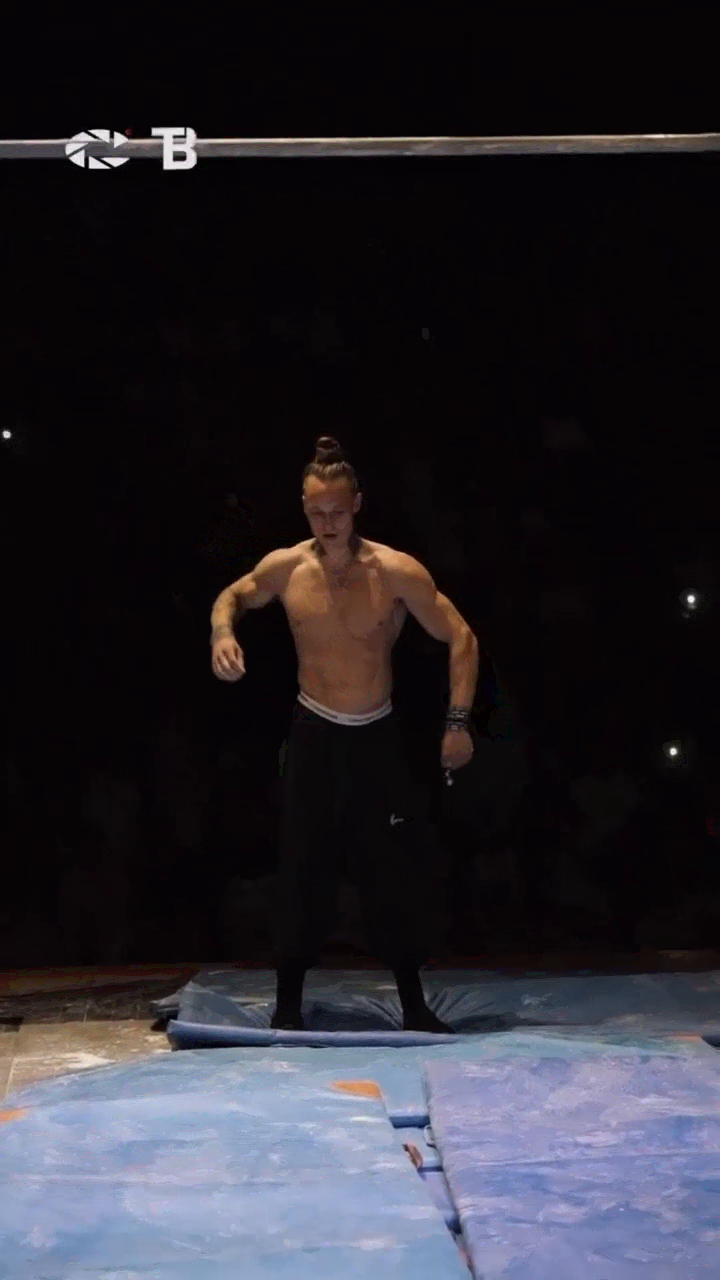

In [7]:
from IPython.display import Image as IPyImage, display
import os

recon_path = "../results/gop001_003.png"

if os.path.exists(recon_path):
    display(IPyImage(filename=recon_path))
else:
    print("No se encontró", recon_path)


# Comparar FRAMES
Ahora vamos a comparar los frames para ver si hay alguna perdida despues del procesamiento, utilizamos uno de los ultimos que es donde hay mas posibilidades de ver alguna perdida. 
Podemos notar un poco de perdida, algo de ruido pero todo bien 

Comparando frame 20
Original     : ../frames/frame_0021.png
Reconstruida : ../results/gop001_004.png


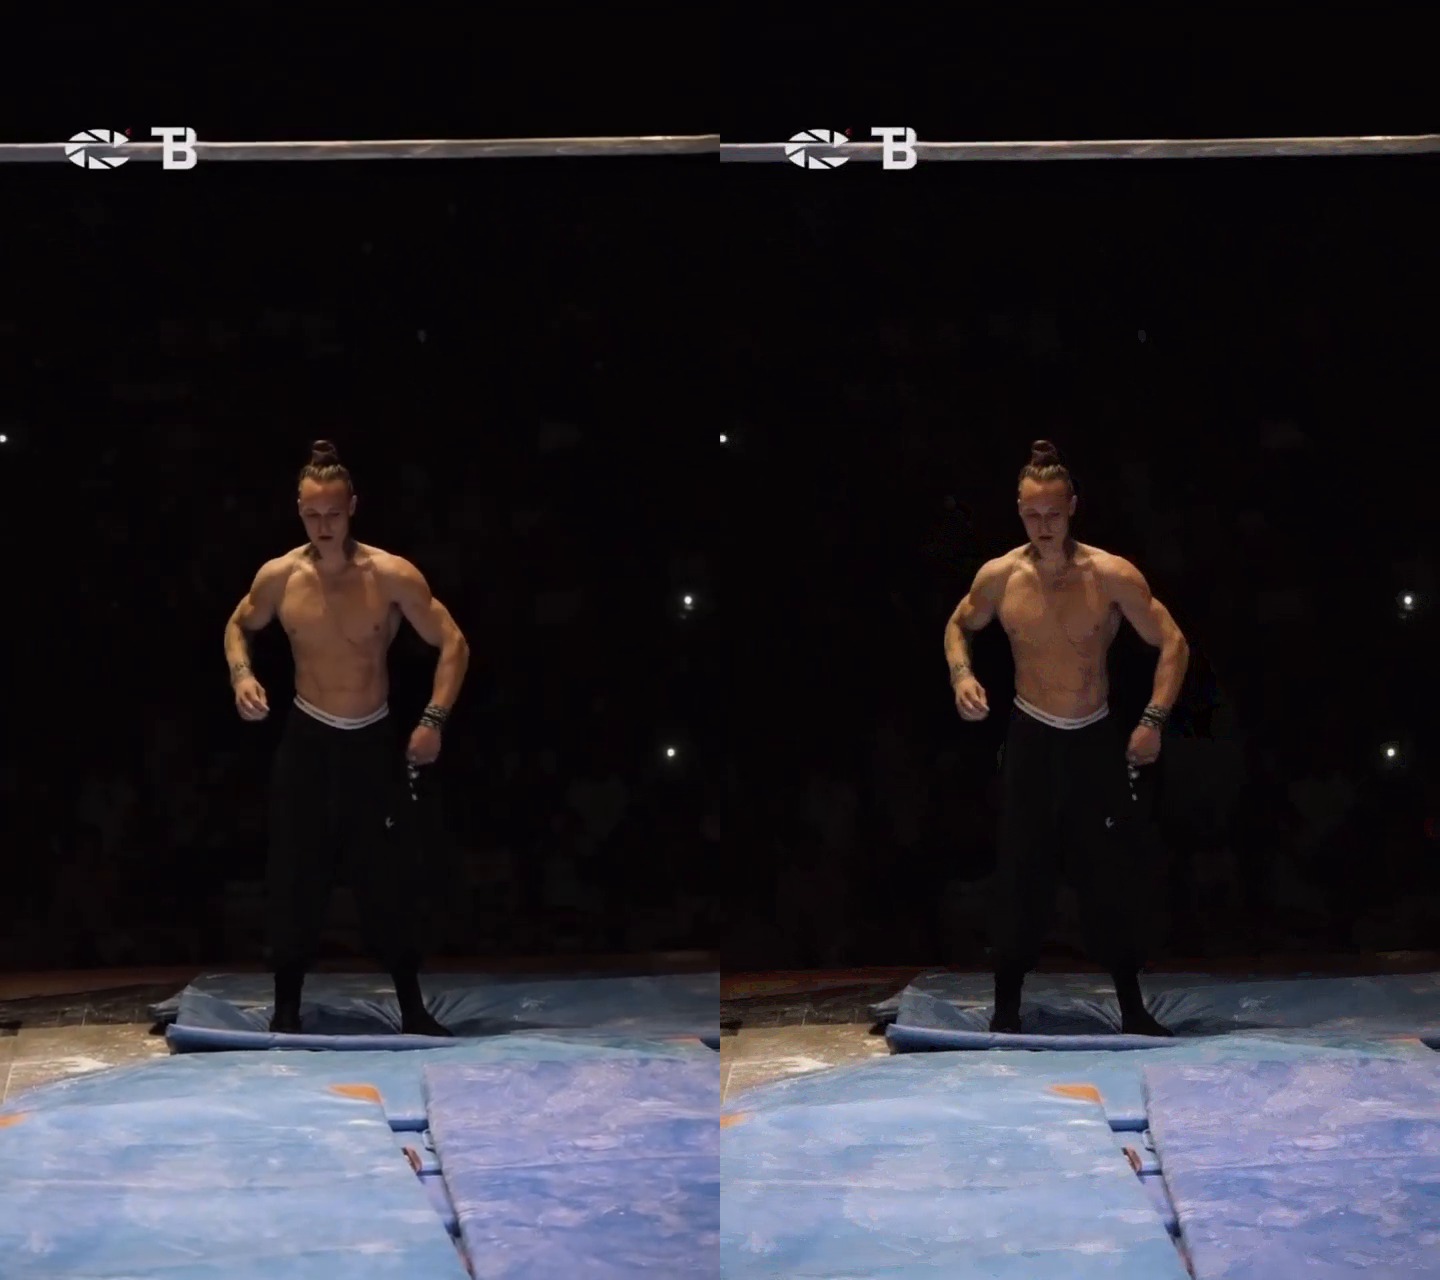

In [8]:
from IPython.display import display
from PIL import Image
import numpy as np
import os

frame_index = 20  

# Cargar listas de archivos
orig_files = sorted([f for f in os.listdir("../frames") if f.lower().endswith((".png",".jpg",".jpeg"))])
recon_files = sorted([f for f in os.listdir("../results") if f.startswith("gop") and f.lower().endswith(".png")])


# Rutas del frame elegido
orig_path = f"../frames/{orig_files[frame_index]}"
recon_path = f"../results/{recon_files[frame_index]}"

print("Comparando frame", frame_index)
print("Original     :", orig_path)
print("Reconstruida :", recon_path)

# Cargar imágenes
orig = np.array(Image.open(orig_path).convert("RGB"))
recon = np.array(Image.open(recon_path).convert("RGB"))
concat = np.hstack((orig, recon))
display(Image.fromarray(concat))